In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_data(train_batch_size, test_batch_size):
    train_data = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_data = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=test_batch_size, shuffle=True)
    return (train_data, test_data)

In [ ]:
class CustomNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def sensitivity(model):
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            fNormAll += fNorm
            counter += 1
    return fNormAll / counter

In [ ]:
def model_optimizer(model, lr):
    return optim.SGD(model.parameters(), lr = lr, momentum=0.9, nesterov=True)

In [ ]:
def train(model, optimizer, train_data):
    model.train()

    for batch_idx, (data, target) in enumerate(train_data):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def calculate_loss(model, loader, loss_fn):
    correct_count = 0
    total = 0
    total_cost = 0
    cost_counter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data)
            cost = loss_fn(output, target)
            total_cost += cost
            cost_counter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct_count += 1
                total += 1
    return total_cost / cost_counter, round(correct_count/total, 3)

In [ ]:
def compute(model, optimizer):
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_data)
        tr_loss, tr_acc = calculate_loss(model, train_data, loss_fn)
        t_loss, t_acc = calculate_loss(model, test_data, loss_fn)
    print("Model Train loss: ", tr_loss)
    loss_tr_arr.append(tr_loss)
    loss_t_arr.append(t_loss)
    train_acc_arr.append(tr_acc)
    test_acc_arr.append(t_acc)
    print("Model Test loss: ", t_loss)

In [ ]:
loss_tr_arr = []
loss_t_arr = []
test_acc_arr = []
train_acc_arr = []
sensList= []
epochs = 30

In [12]:
batch_size = [100, 250, 500, 5000, 10000]
for batch in batch_size:
    torch.manual_seed(1)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_data, test_data = load_data(batch, batch)
    model1 = CustomNet()
    optimizer = model_optimizer(model1,lr=0.01)
    compute(model1, optimizer)
    sensList.append(sensitivity(model1))

Files already downloaded and verified
Model Train loss:  tensor(0.3445)
Model Test loss:  tensor(1.5368)
Files already downloaded and verified
Model Train loss:  tensor(0.5379)
Model Test loss:  tensor(1.1901)
Files already downloaded and verified
Model Train loss:  tensor(0.7919)
Model Test loss:  tensor(1.0456)
Files already downloaded and verified
Model Train loss:  tensor(1.7971)
Model Test loss:  tensor(1.7862)
Files already downloaded and verified
Model Train loss:  tensor(2.1882)
Model Test loss:  tensor(2.1830)


In [13]:
def clean_arr(arr):
    temp_1 = []
    for i in arr:
        temp_1.append(i.data.numpy().tolist())
    return temp_1

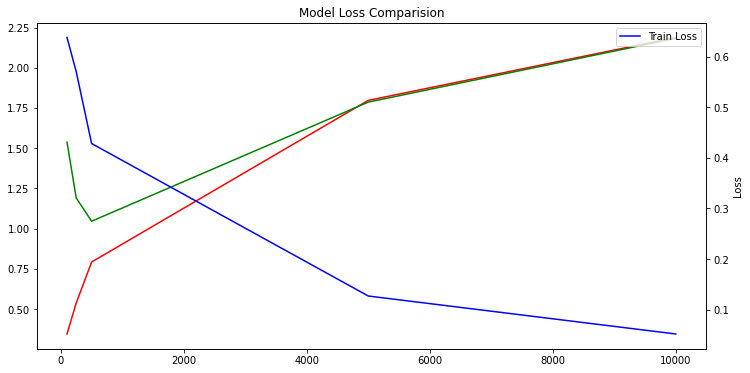

In [14]:
plt.figure(figsize=(12,6))
plt.plot(batch_size, loss_tr_arr, color = "r")
plt.plot(batch_size, loss_t_arr, color = "g")
ax2 = plt.twinx()
plt.plot(batch_size, sensList, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

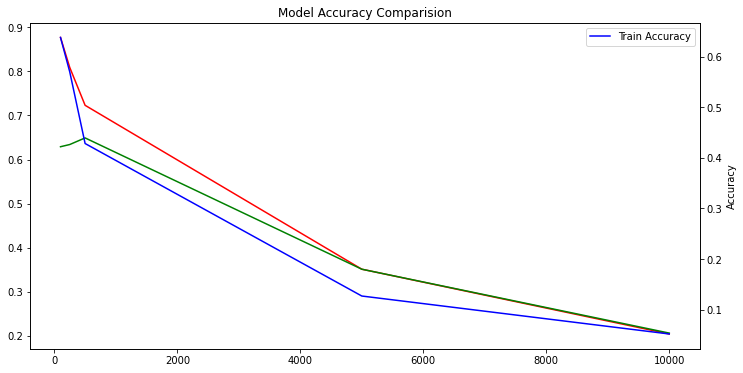

In [15]:
plt.figure(figsize=(12,6))
plt.plot(batch_size, train_acc_arr, color = "r")
plt.plot(batch_size, test_acc_arr, color = "g")
ax2 = plt.twinx()
plt.plot(batch_size, sensList, color = "b")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()